![Aeropython logo](./static/aeropython_name_mini.png)
###### Carlos Dorado Cárdenas
###### Siro Moreno Martín

# Simplifica tu vida con sistemas complejos y algoritmos genéticos

## Bloque B2 - Algoritmos genéticos

In [1]:
import numpy as np
import random as random
from IPython.html.widgets import interact
import matplotlib.pyplot as plt
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class Individual (object):
    
    def __init__(self, genome):
        
        self.genome = genome        
        self.traits = {}
        self.performances = {}
        self.fitness = 0

El genoma es donde está codificada la información que sirve para construir una solución. Mientras se sea coherente, el genoma se puede definir con total libertad según se necesite: números reales, enteros, letras... En el mundo informático todo está codificado en estados binarios, así que haremos que nuestro genoma será una cadena de ceros y unos. 

Para ello vamos a utilizar un diccionario genético que defina los genes de nuestro individuo y su longitud. En este caso, nuestro individuo sólo presenta dos características, que son las coordenadas de un punto, por lo que sólo habrá dos genes. Vamos a utilizar 10 dígitos, que nos permiten codificar 1024 estados diferentes.

In [3]:
dict_genes = {
    'x1' : 10,
    'x2' : 10,
}

Vamos a necesitar crear individuos aleatorios, para lo que utilizaremos una función "Generar genoma":

In [4]:
generate_random_binary_list = lambda n: [random.randint(0,1) for b in range(1,n+1)]

def generate_genome (dict_genes):
    
    #We first calculate the total number of bits that the genome must contain
    number_of_bits = sum([dict_genes[trait] for trait in dict_genes])
    
    #And we return a random genome of this length
    return generate_random_binary_list(number_of_bits)

Cuando ya tengamos nuestros individuos, con su material genético, necesitaremos una función que nos descifre este código y lo traduzca a características reconocibles del mismo. En el mundo real sería como leer el "gen del color de los ojos" (en realidad son varios genes) para descubrir que el contenido de ese gen en concreto indica que el individuo tiene "ojos azules".

In [6]:
def calculate_traits (individual, dict_genes, minimum, maximum):
    #This function must decipher the genome and return the traits of the individual.
    #Normally, the genome contains binary numerical values for the different traits.
    
    dict_traits = {}
    index = 0
    
    for trait in dict_genes:
        step = (maximum-minimum) / (int(dict_genes[trait]*'1',2))
        dict_traits[trait] = minimum + step*int(''.join(str(bit) for bit in individual.genome[index : index+dict_genes[trait]]), 2)
        index += dict_genes[trait]
        
    individual.traits = dict_traits

En el mundo natural, las características de un individuo determinarán en gran parte cómo de bien o de mal se desenvolverá en la vida, esto es, sus "actuaciones", "desempeño" o, en inglés, su "performance". Si tiene las piernas más largas, podrá correr más rápido; si tiene unos dientes afilados, podrá defenderse mejor... En nuestro ejemplo esto no es ni más ni menos que el eje vertical de nuestra función de coste.

In [8]:
from codigo import goldstein_price

In [9]:
def calculate_performances (individual):
    
    dict_perfo = {
        
        'cost' : goldstein_price([individual.traits['x1'], individual.traits['x2']])

    }
    
    individual.performances = dict_perfo

Según sean de buenas sus actuaciones, el individuo será más apto, estará mejor adaptado. En nuestro problema se trata de **definir qué es una solución buena**, y aquí se haya una de las armas más potentes del algoritmo genético. **El algoritmo genético nos obliga a definir qué es lo que estamos buscando en nuestro proceso de optimización mediante una función.**

Para simplificareste ejemplo, vamos a utilizar directamente el valor del coste:
$$ Aptitud = - Coste $$

In [11]:
def calculate_fitness (individual):
        
    individual.fitness = - individual.performances['cost']

Ahora ya podemos generar nuestras soluciones y tenemos medios para evaluarlas. Es hora de hacer que la selección natural haga su trabajo.

Primero necesitamos crear una población. Una manera de hacer esto es mediante una función de inmigración, que genere una sociedad formada por una determinada cantidad de individuos exóticos, generados de manera aleatoria:

In [13]:
def immigration (society, target_population, dict_genes, minimum, maximum):
    
    while len(society) < target_population:
        
        new_individual = Individual (generate_genome (dict_genes))
        calculate_traits (new_individual, dict_genes, minimum, maximum)
        calculate_performances (new_individual)
        calculate_fitness (new_individual)
        
        society.append (new_individual)

Ahora, los individuos de esta sociedad se reproducen entre ellos, generando nuevos individuos. Los individuos más aptos tienen más probabilidades de reproducirse que los menos aptos, con lo que las mejores soluciones generan más descendencia. Durante la concepción, los nuevos individuos sufren pequeñas mutaciones aleatorias. Después nacen y se incorporan a la sociedad.

In [15]:
#This function was taken from Eli Bendersky's website
#It returns an index of a list called "weights", 
#where the content of each element in "weights" is the probability of this index to be returned.
#For this function to be as fast as possible we need to pass it a list of weights in descending order.
def weighted_choice_sub(weights):
    """
    weights = [0.9, 0.05, 0.05]
    N = 100000
    lista = [weighted_choice_sub(weights) for ii in range(N)]
    print( lista.count(0)/N, lista.count(1)/N, lista.count(2)/N)
    """
    rnd = random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i

def crossover (society, reproduction_rate, mutation_rate, minimum, maximum):
    
    #First we create a list with the fitness values of every individual in the society
    fitness_list = [individual.fitness for individual in society]
    
    #We sort the individuals in the society in descending order of fitness.   
    society_sorted = [x for (y, x) in sorted(zip(fitness_list, society), key=lambda x: x[0], reverse=True)] 
    
    #We then create a list of relative probabilities in descending order, 
    #so that the fittest individual in the society has N times more chances to reproduce than the least fit,
    #where N is the number of individuals in the society.
    probability = [i for i in reversed(range(1,len(society_sorted)+1))]
    
    #We create a list of weights with the probabilities of non-mutation and mutation
    mutation = [1 - mutation_rate, mutation_rate]    
    
    #For every new individual to be created through reproduction:
    for i in range (int(len(society) * reproduction_rate)):
        
        #We select two parents randomly, using the list of probabilities in "probability".
        father, mother = society_sorted[weighted_choice_sub(probability)], society_sorted[weighted_choice_sub(probability)]
        
        #We randomly select two cutting points for the genome.
        a, b = random.randrange(0, len(father.genome)), random.randrange(0, len(father.genome))
        
        #And we create the genome of the child putting together the genome slices of the parents in the cutting points.
        child_genome = father.genome[0:min(a,b)]+mother.genome[min(a,b):max(a,b)]+father.genome[max(a,b):]
        
        #For every bit in the not-yet-born child, we generate a list containing 
        #1's in the positions where the genome must mutate (i.e. the bit must switch its value)
        #and 0's in the positions where the genome must stay the same.
        n = [weighted_choice_sub(mutation) for ii in range(len(child_genome))]
        
        #This line switches the bits of the genome of the child that must mutate.
        mutant_child_genome = [abs(n[i] -  child_genome[i]) for i in range(len(child_genome))]
        
        #We finally append the newborn individual to the society
        newborn = Individual(mutant_child_genome)
        calculate_traits (newborn, dict_genes, minimum, maximum)
        calculate_performances (newborn)
        calculate_fitness (newborn)
        society.append(newborn)        

En el mundo natural, la escasez de recursos obliga a los individuos a competir. Una función de torneo escoge parejas de soluciones al azar, las compara y elimina las menos aptas.

In [17]:
def tournament(society, target_population):
    
    while len(society) > target_population:
        
        #index1, index2 = random.randrange(0, len(society)), random.randrange(0, len(society))
        #if society[index1].fitness > society[index2].fitness:
        #    society.pop(index2)
        #else:
        #    society.pop(index1)
                
        fitness_list = [individual.fitness for individual in society]
        society.pop(fitness_list.index(min(fitness_list)))

Ahora podemos crear una función que aplique el algoritmo genético a este problema concreto:

In [19]:
def genetic_algorithm (minimum = -2,
                       maximum = 2,
                       number_of_genes = 20,
                       size_of_society = 50, 
                       reproduction_rate = 0.4,
                       mutation_rate = 0.1, 
                       number_of_generations = 10,
                       size_after_tournament = 40,
                      ):

    
    dict_genes = {'x1' : number_of_genes,
                  'x2' : number_of_genes,
                 }
    
            
    society = []
    fitness_max = []
    fitness_avg = []

    for generation in range(number_of_generations):
    
        immigration (society, size_of_society, dict_genes, minimum, maximum)
        fitness_max += list([max([individual.fitness for individual in society])])
        fitness_avg += list([np.mean([individual.fitness for individual in society])])
        crossover(society, reproduction_rate, mutation_rate, minimum, maximum)
        tournament (society, size_after_tournament)
    
    fitness_list = [individual.fitness for individual in society]
    winner = society[fitness_list.index(max(fitness_list))]
    print(winner.traits)
    
        
    plt.figure(figsize=(15,5))
    plt.plot(fitness_max)
    plt.title('$\Phi_{max} = $' + str(round(fitness_max[-1], 5)), fontsize = 15)  
    
    plt.figure(figsize=(15,5))
    plt.plot(fitness_avg)
    plt.title('$\overline{\Phi}$', fontsize = 15)  

{'x1': -0.006483084185680665, 'x2': -0.9444112247574088}


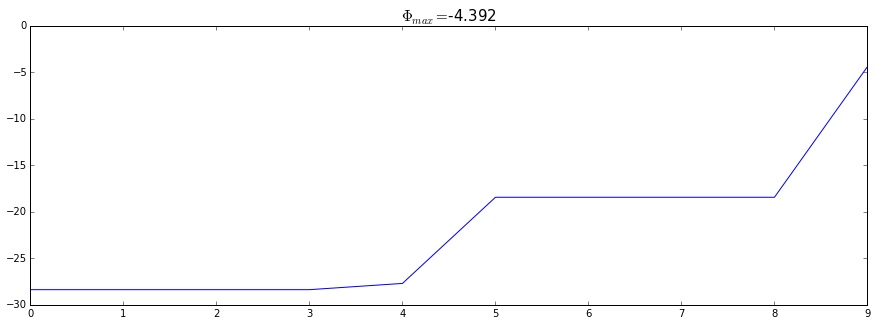

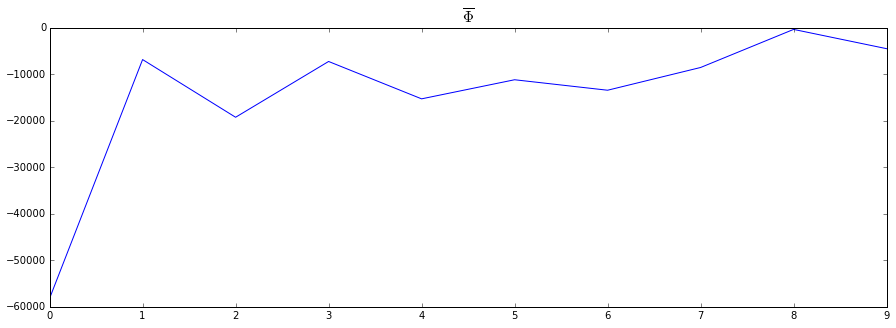

In [20]:
genetic_algorithm()

Vemos que alcanzamos el resultado con muchas menos evaluaciones de la función que el algoritmo heurístico más básico (350 frente a 100000 del ascenso de colinas con reinicios aleatorios). Hemos duplicado el rendimiento para esta función 2D, pero las mejoras de rendimiento son más espectaculares cuanto mayor es la dimensión del problema que se quiere optimizar.

##Ejercicio: 

Usando este algoritmo genético, minimiza la función de la "huevera" en el cuadrado x1, x2 ∈ [-512, 512].
Esta función está llena de óptimos locales, cambia los parámetros del problema para ver su influencia en la convergencia.
El óptimo absoluto vale -959.6407 y se encuentra en el punto (512, 404.2319).

In [21]:
from codigo import eggholder

<img src=imagenes/eggholder.png alt="Función de Huevera" style="width: 500px;"/>

In [22]:
def calculate_performances (individual):
    
    dict_perfo = {
        
        'cost' : eggholder([individual.traits['x1'], individual.traits['x2']])

    }
    
    individual.performances = dict_perfo

In [23]:
def genetic_algorithm (minimum = -512,
                       maximum = 512,
                       number_of_genes = 15,
                       size_of_society = 60, 
                       reproduction_rate = 0.5,
                       mutation_rate = 0.2, 
                       number_of_generations = 100,
                       size_after_tournament = 40,
                      ):

    
    dict_genes = {'x1' : number_of_genes,
                  'x2' : number_of_genes,
                 }
    
            
    society = []
    fitness_max = []
    fitness_avg = []

    for generation in range(number_of_generations):
    
        immigration (society, size_of_society, dict_genes, minimum, maximum)
        fitness_max += list([max([individual.fitness for individual in society])])
        fitness_avg += list([np.mean([individual.fitness for individual in society])])
        crossover(society, reproduction_rate, mutation_rate, minimum, maximum)
        tournament (society, size_after_tournament)
    
    fitness_list = [individual.fitness for individual in society]
    winner = society[fitness_list.index(max(fitness_list))]
    print(winner.traits)
    
        
    plt.figure(figsize=(15,5))
    plt.plot(fitness_max)
    plt.title('$\Phi_{max} = $' + str(round(fitness_max[-1], 5)), fontsize = 15)  
    
    plt.figure(figsize=(15,5))
    plt.plot(fitness_avg)
    plt.title('$\overline{\Phi}$', fontsize = 15) 

{'x1': 487.97653958944284, 'x2': 442.93255131964804}


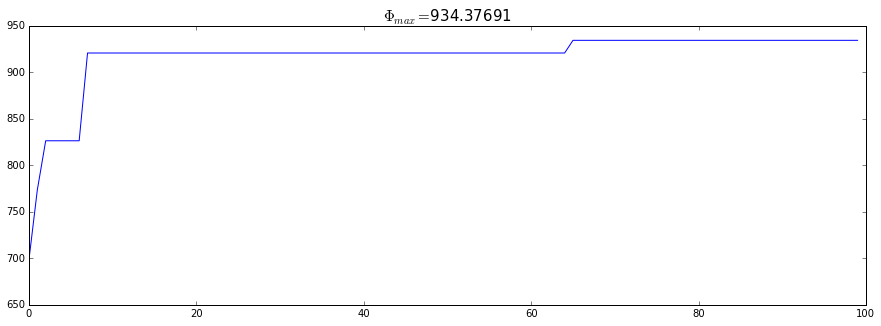

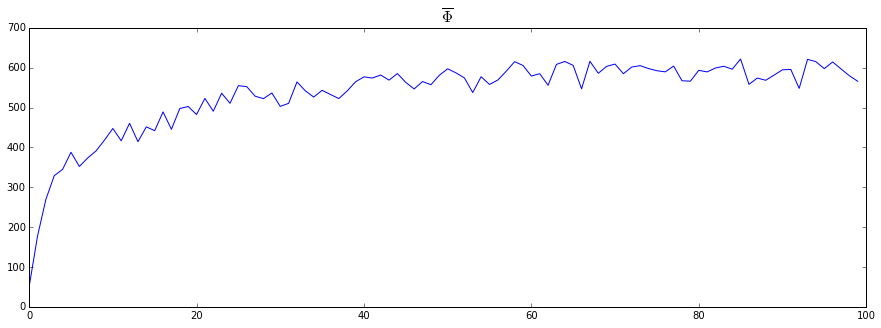

In [24]:
w = interact(genetic_algorithm,
             minimum = (-512, 0, 1),
             maximum = (0, 512, 1),
             number_of_genes = (1, 50, 1),
             size_of_society = (1, 100, 1), 
             reproduction_rate = (0, 1, 0.01), 
             mutation_rate = (0, 1, 0.01),
             number_of_generations = (1, 200, 1),
             size_after_tournament = (1, 100, 1)
            )

El tamaño del genoma, esto es, el número de bits utilizados para describir al individuo, determina la cantidad de soluciones posibles, por lo que abre la puerta a mejores optimizaciones. Un genoma mayor supone asimismo una mayor dificultad para converger, debido a que hay muchas más combinaciones posibles a probar.

El tamaño de la población es, probablemente el factor más importante. El tiempo de cálculo aumenta de forma directamente proporcional al tamaño de la población, por lo que hay que tener cuidado al elegir el tamaño apropiado.

Una población pequeña, aunque mejora los tiempos, puede ser víctima del llamado “efecto del fundador”, en los que una baja variabilidad genética en el origen y, en general, un tamaño poblacional pequeño, hacen que la “deriva genética” lleve a la población a presentar una serie de rasgos comunes que no necesariamente se corresponden con los de los individuos más aptos, que sí se observan fuera de ella.

Para evitar este problema, se pueden introducir altas tasas de inmigración y mutación. Si la población es pequeña, es muy sensible, por lo que la media de la función de aptitud evoluciona de manera muy turbulenta y puede, incluso, alejarse de la convergencia

Por el contrario, una población grande es garantía de una gran variedad genética inicial. Estadísticamente, también es más probable que se encuentre antes la solución, aunque la convergencia sea más lenta. Además, el gran número estabiliza la evolución de la función de mérito media y hace que la población sea más robusta frente a la inmigración y la mutación.

Si te está gustando este taller:

In [25]:
%%html
<a href="https://twitter.com/share" class="twitter-share-button" data-url="https://github.com/AeroPython/Taller-Algoritmos-Geneticos-PyConEs16" data-text="Aprendiendo Algoritmos Genéticos y Sistemas Complejos con" data-via="AeroPython" data-size="large" data-hashtags="PyConEs" data-dnt="true">Tweet</a>
<script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>

Carlos Dorado, Aeropython, 7 de Octubre de 2016

In [26]:
# Notebook style
from IPython.core.display import HTML
css_file = './static/style.css'
HTML(open(css_file, "r").read())